# 한국어 word2vec 작성

- CBOW, window size 2 의 simplified word2vec model 작성

In [ ]:
# Install konlpy
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
# Install Korean fonts
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

세션을 재시작하시오.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import numpy as np
import re

### Toy 말뭉치

In [2]:
corpus = ['왕은 매우 강한 남자이다',
          '여왕은 현명한 예쁜 여자이다',
          '소년은 젊은 남자이다',
          '소녀는 젊은 예쁜 여자이다',
          '왕자는 젊고 현명한 왕이 될 것이다',
          '공주는 젊고 예쁜 현명한 여왕이 될 것이다',
          '남자는 강하다',
          '여자는 예쁘다',
          '왕자는 왕이 될 소년이다',
          '공주는 왕비가 될 소녀이다']

In [3]:
cleaned_corpus = []
for text in corpus:
    print(text)
    text = re.sub(r'[^a가-힣]', '', text)  #한글
    cleaned_corpus.append(text.lower())

왕은 매우 강한 남자이다
여왕은 현명한 예쁜 여자이다
소년은 젊은 남자이다
소녀는 젊은 예쁜 여자이다
왕자는 젊고 현명한 왕이 될 것이다
공주는 젊고 예쁜 현명한 여왕이 될 것이다
남자는 강하다
여자는 예쁘다
왕자는 왕이 될 소년이다
공주는 왕비가 될 소녀이다


### stopword 제거

In [4]:
from konlpy.tag import Okt
okt = Okt()
okt.morphs

<bound method Okt.morphs of <konlpy.tag._okt.Okt object at 0x7e6c688ebdc0>>

In [5]:
stop_words = ['은', '가', '이다', '는', '이', '될']

results = []

for text in corpus:
    tmp = []
    for word in okt.morphs(text):
        if word not in stop_words:
            tmp.append(word)
    results.append(' '.join(tmp))

In [6]:
cleaned_corpus = results
cleaned_corpus

['왕 매우 강한 남자',
 '여왕 현명한 예쁜 여자',
 '소년 젊은 남자',
 '소녀 젊은 예쁜 여자',
 '왕자 젊고 현명한 왕 것',
 '공주 젊고 예쁜 현명한 여왕 것',
 '남자 강하다',
 '여자 예쁘다',
 '왕자 왕 소년',
 '공주 왕비 소녀']

### vocaburary 모음 작성

In [7]:
words = []

for sentence in cleaned_corpus:
    for word in sentence.split(' '):
        words.append(word)

words = list(set(words))
words

['소년',
 '현명한',
 '것',
 '남자',
 '왕자',
 '공주',
 '왕',
 '여자',
 '젊고',
 '강한',
 '강하다',
 '여왕',
 '예쁜',
 '소녀',
 '젊은',
 '왕비',
 '예쁘다',
 '매우']

### word-to-index, index-to-word 작성

- word 를 index 로 변환  

- sentence 를 word index 로 변환  

- window size 에 따라 train data 생성

In [8]:
word2index = dict((w, i) for i, w in enumerate(words))
index2word = dict((i, w) for i, w in enumerate(words))

In [9]:
word2index

{'소년': 0,
 '현명한': 1,
 '것': 2,
 '남자': 3,
 '왕자': 4,
 '공주': 5,
 '왕': 6,
 '여자': 7,
 '젊고': 8,
 '강한': 9,
 '강하다': 10,
 '여왕': 11,
 '예쁜': 12,
 '소녀': 13,
 '젊은': 14,
 '왕비': 15,
 '예쁘다': 16,
 '매우': 17}

### CBOW 로 training data 생성

In [10]:
sentences = []
for sentence in cleaned_corpus:
    sentences.append(sentence.split())
sentences

[['왕', '매우', '강한', '남자'],
 ['여왕', '현명한', '예쁜', '여자'],
 ['소년', '젊은', '남자'],
 ['소녀', '젊은', '예쁜', '여자'],
 ['왕자', '젊고', '현명한', '왕', '것'],
 ['공주', '젊고', '예쁜', '현명한', '여왕', '것'],
 ['남자', '강하다'],
 ['여자', '예쁘다'],
 ['왕자', '왕', '소년'],
 ['공주', '왕비', '소녀']]

In [11]:
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] :
            if neighbor != word:
                data.append([word, neighbor])

In [12]:
data[:10]

[['왕', '매우'],
 ['왕', '강한'],
 ['매우', '왕'],
 ['매우', '강한'],
 ['매우', '남자'],
 ['강한', '왕'],
 ['강한', '매우'],
 ['강한', '남자'],
 ['남자', '매우'],
 ['남자', '강한']]

skip-gram과 CBOW의 차이점은 인풋과 라벨의 순서를 반대로 바꿔주는 것이다.

In [13]:
import pandas as pd

df = pd.DataFrame(data, columns = ['label', 'input'])
df.head()

,label,input
0,왕,매우
1,왕,강한
2,매우,왕
3,매우,강한
4,매우,남자


### One hot encoding

In [14]:
from tensorflow.keras.utils import to_categorical

len(words)

18

### One hot encoding 된 train, label data

In [15]:
X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_categorical(word2index[x], len(words)))
    Y.append(to_categorical(word2index[x], len(words)))

In [16]:
print(X[:3])
print(Y[:3])

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)]


In [17]:
# convert them to numpy arrays
X_train = np.array(X)
Y_train = np.array(Y)

**시각화를 위해 hidden layer 의 unit 을 2 로 제한**

In [18]:
model = Sequential()
model.add(Dense(2, input_dim=len(words)))
model.add(Dense(len(words)))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [19]:
model.fit(X_train, Y_train, epochs=500, batch_size=3)

Epoch 1/500
28/28 [==============================] - 1s 2ms/step - loss: 4.9650 - accuracy: 0.0119 
Epoch 2/500
28/28 [==============================] - 0s 2ms/step - loss: 5.4947 - accuracy: 0.0595
Epoch 3/500
28/28 [==============================] - 0s 2ms/step - loss: 5.8641 - accuracy: 0.0595
Epoch 4/500
28/28 [==============================] - 0s 2ms/step - loss: 4.8058 - accuracy: 0.0595
Epoch 5/500
28/28 [==============================] - 0s 2ms/step - loss: 6.3513 - accuracy: 0.0595    
Epoch 6/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8282 - accuracy: 0.0595 
Epoch 7/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8266 - accuracy: 0.0595    
Epoch 8/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8266 - accuracy: 0.0595
Epoch 9/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8266 - accuracy: 0.0595 
Epoch 10/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8266 - accuracy: 0.059

### 첫번째 Hidden Layer 추출 및 weight + bias 를 vector 로 합산

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 38        
                                                                 
 dense_1 (Dense)             (None, 18)                54        
                                                                 
Total params: 92 (368.00 Byte)
Trainable params: 92 (368.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.layers[0].get_weights()

[array([[ 0.07991884,  0.45559525],
        [ 0.55792356,  0.28252584],
        [-0.14378543, -0.05061423],
        [ 0.5531177 , -0.08560189],
        [ 0.40152496,  0.44734973],
        [ 0.15297276, -0.31902266],
        [-0.37556025, -0.31404105],
        [-0.35905296,  0.00718742],
        [ 0.18037415,  0.02160347],
        [ 0.49849617, -0.41262153],
        [-0.26172408, -0.22816081],
        [-0.26323205,  0.47246045],
        [ 0.18599282, -0.5192698 ],
        [-0.20204976,  0.17797166],
        [-0.16526797, -0.46528098],
        [ 0.38084984, -0.15414804],
        [-0.09870271,  0.49148402],
        [-0.06107356, -0.34182853]], dtype=float32),
 array([-0.01993631,  0.00784895], dtype=float32)]

In [22]:
vectors= model.layers[0].get_weights()[0] + model.layers[0].get_weights()[1]
vectors[:5]

array([[ 0.05998253,  0.4634442 ],
       [ 0.53798723,  0.2903748 ],
       [-0.16372174, -0.04276528],
       [ 0.53318137, -0.07775294],
       [ 0.38158864,  0.45519868]], dtype=float32)

In [23]:
words

['소년',
 '현명한',
 '것',
 '남자',
 '왕자',
 '공주',
 '왕',
 '여자',
 '젊고',
 '강한',
 '강하다',
 '여왕',
 '예쁜',
 '소녀',
 '젊은',
 '왕비',
 '예쁘다',
 '매우']

In [24]:
w2v = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v['word'] = words
w2v

,x1,x2,word
0,0.059983,0.463444,소년
1,0.537987,0.290375,현명한
2,-0.163722,-0.042765,것
3,0.533181,-0.077753,남자
4,0.381589,0.455199,왕자
5,0.133036,-0.311174,공주
6,-0.395497,-0.306192,왕
7,-0.378989,0.015036,여자
8,0.160438,0.029452,젊고
9,0.478560,-0.404773,강한


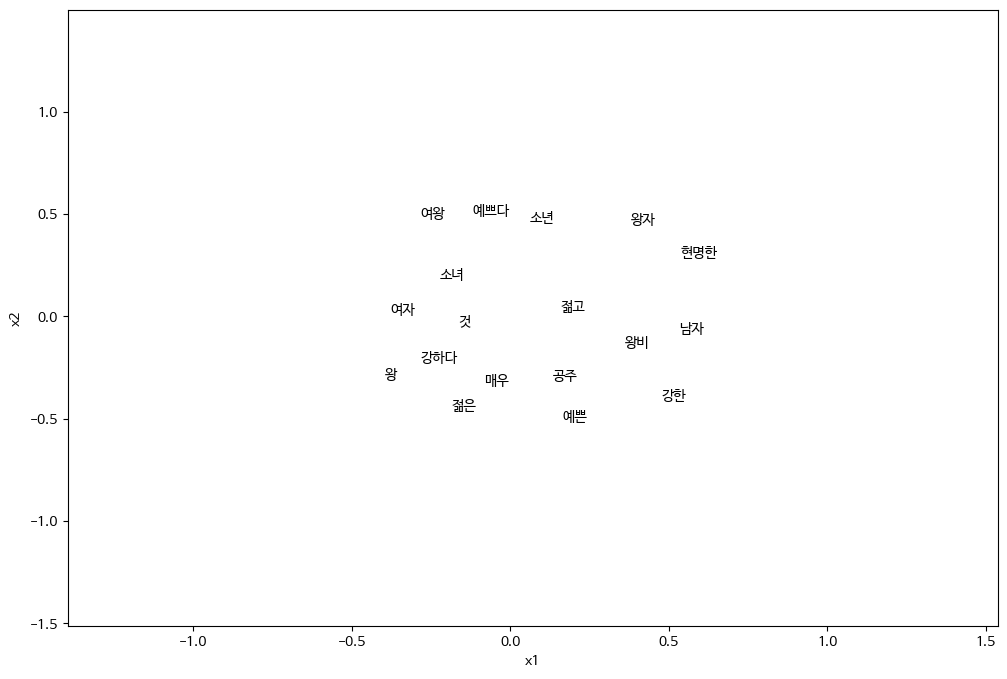

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False               #한글사용시 마이너스 사인 깨짐 방지


fig, ax = plt.subplots(figsize=(12,8))

for word, x1, x2 in zip(w2v['word'], w2v['x1'], w2v['x2']):
    ax.annotate(word, (x1, x2))

PADDING = 1.0
x_axis_min = np.min(vectors, axis=0)[0] - PADDING
y_axis_min = np.min(vectors, axis=0)[1] - PADDING
x_axis_max = np.max(vectors, axis=0)[0] + PADDING
y_axis_max = np.max(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()